In [2]:
%run package_import.ipynb
%run data_profiling.ipynb

In [3]:
from sqlalchemy import create_engine, types
import pymysql

sqlEngine       = create_engine('mysql+pymysql://root:@127.0.0.1/kaggle_hour_price', pool_recycle=3600)
dbConnection    = sqlEngine.connect()

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
df_combined = pd.read_sql_query(

''' 
select *,
    'train' as source
from raw_train

union all

select *, 
    cast(null as float) as SalePrice,
    'test' as source
from raw_test
'''
,dbConnection)

In [6]:
df_profile = main_data_profiling(df_combined)

In [7]:
df_profile

,column_names,data_type,unique_count,min_value,max_value,mean_value,median_value,null_values,total_rows,%_null_values,num_lower_outliers,num_higher_outliers
0,Id,int64,2919,1.0,2919.0,1460.000000,1460.0,0,2919,0.000000,0.0,0.0
1,MSSubClass,int64,16,20.0,190.0,57.137718,50.0,0,2919,0.000000,0.0,207.0
2,MSZoning,object,6,NaN,NaN,NaN,NaN,4,2919,0.001370,NaN,NaN
3,LotFrontage,float64,129,21.0,313.0,69.305795,68.0,486,2919,0.166495,104.0,94.0
4,LotArea,int64,1951,1300.0,215245.0,10168.114080,9453.0,0,2919,0.000000,1.0,127.0
5,Street,object,2,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
6,Alley,object,3,NaN,NaN,NaN,NaN,2721,2919,0.932169,NaN,NaN
7,LotShape,object,4,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
8,LandContour,object,4,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
9,Utilities,object,3,NaN,NaN,NaN,NaN,2,2919,0.000685,NaN,NaN


### ETL Process

In [8]:
# The loop is to convert description to jason to fill na value
# initalise the dictionary
desc_dict, attr_dict, col_desc = {}, {}, {}
with open('/Users/liuyifu/Project_data/House_Prices/data_description.txt', encoding='utf8') as f:
    for line in f:
        # convert line into list
        words = line.split()
        # if the line contains ":", the line includes a column
        # and its description
        if words and ':' in line:
            # convert the line into list, recognise the first item from the list
            # as the column and remove ":"
            col = words[0].replace(':','')
            # save the column as a key into description dictionary
            desc_dict[col] = {}
            col_desc[col] = ' '.join(words[1:])
        # if the line is blank, move to the next one
        elif  not words:
            continue
        else:
            # the attr_desc is to contain values for each column
            # concatenate items except the value from the list to 
            # rebuild the description of each value
            attr_desc = ' '.join(words[1:])
            # store the first item of the list as the value
            attr = words[0]
            # save the the attribute dictionary as sub-dictionary to
            # description description
            desc_dict[col][attr] = attr_desc

In [9]:
df_profile = main_data_profiling(df_combined)
df_profile.insert(1, 'col_desc', np.nan)
df_profile.insert(2, 'value_desc', np.nan)
df_profile['col_desc'] = df_profile['column_names'].map(col_desc)
df_profile['value_desc'] = df_profile['column_names'].map(desc_dict)
df_profile['value_desc'] = df_profile['value_desc'].astype('str')

#### 1. Replace NA

In [10]:
df_combined['SaleType'] = df_combined['SaleType'].fillna('WD')
df_combined['MSZoning'] = df_combined['MSZoning'].fillna('RL')
df_combined['Functional'] = df_combined['Functional'].fillna('Typ')
df_combined['Utilities'] = df_combined['Utilities'].fillna('AllPub')
df_combined['Electrical'] = df_combined['Electrical'].fillna('SBrkr')
df_combined['KitchenQual'] = df_combined['KitchenQual'].fillna('TA')
df_combined['Exterior2nd'] = df_combined['Exterior2nd'].fillna('VinylSd')
df_combined['Exterior1st'] = df_combined['Exterior1st'].fillna('VinylSd')

# the loop is to fill na value based on descriptioin automatically
for col in df_combined.columns:
    # if a column has null value and its value includes "NA"
    # replace NA with the value mentioned in the description;
    # otherwise, skip it. 
    if df_profile[df_profile['column_names'] == col]['null_values'].squeeze() > 0:
        if df_profile[df_profile['column_names'] == col]['data_type'].squeeze() == 'object':
                    df_combined[col] = df_combined[col].fillna('No')
        elif df_profile[df_profile['column_names'] == col]['data_type'].squeeze() == 'float64':
            df_combined[col] = df_combined[col].fillna(0)

#### 2. Check duplication

In [11]:
df_combined[df_combined.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source


#### map rates for quality

In [12]:
marks = {"No":-1, "Po": 0, 'Fa': 1, "TA": 2, 'Gd': 3, 'Ex': 4}
cols_marks = []

for col in df_combined.columns:
    marks_exist = 1
    for i in df_combined[col].unique():
        if i in marks:
            pass
        else:
            marks_exist = 0
            break
    
    if marks_exist == 1:
        cols_marks.append(col)


for col in cols_marks:
    df_combined[col] = df_combined[col].map(marks).astype('int')

In [13]:
# map BsmtExposure
masks2 = {'Gd': 2, 'Av': 1, 'Mn': 0, 'No': -1}

df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map(masks2)

In [14]:
# GarageFinish
masks4 = {'Fin': 2, 'RFn': 1, 'Unf': 0, 'No': -1}
df_combined['GarageFinish'] = df_combined['GarageFinish'].map(masks4).astype('int')

In [15]:
masks5 = {'Y': 1, 'P': 0, 'N': -1}
df_combined['PavedDrive'] = df_combined['PavedDrive'].map(masks5).astype('int')

In [16]:
df_combined['CentralAir'] = df_combined['CentralAir'].map({'Y': 1, 'N': 0}).astype('int')

In [17]:
df_combined['Fence'] = df_combined['Fence'].map({'GdPrv': 3, 'MnPrv': 2, 'GdWo': 1, 'MnWw': 0, 'No': -1}).astype('int')

In [18]:
cate_cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish',
                'PavedDrive', 'CentralAir', 'Fence','ExterQual',
                'ExterCond',
                'BsmtQual',
                'BsmtCond',
                'HeatingQC',
                'KitchenQual',
                'FireplaceQu',
                'GarageQual',
                'GarageCond',
                'PoolQC'
                ]

In [19]:
main_data_profiling(df_combined)

,column_names,data_type,unique_count,min_value,max_value,mean_value,median_value,null_values,total_rows,%_null_values,num_lower_outliers,num_higher_outliers
0,Id,int64,2919,1.0,2919.0,1460.000000,1460.0,0,2919,0.0,0.0,0.0
1,MSSubClass,int64,16,20.0,190.0,57.137718,50.0,0,2919,0.0,0.0,207.0
2,MSZoning,object,5,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
3,LotFrontage,float64,129,0.0,313.0,57.766701,63.0,0,2919,0.0,0.0,31.0
4,LotArea,int64,1951,1300.0,215245.0,10168.114080,9453.0,0,2919,0.0,1.0,127.0
5,Street,object,2,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
6,Alley,object,3,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
7,LotShape,object,4,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
8,LandContour,object,4,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
9,Utilities,object,2,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN


#### Feature engineer

In [20]:
df_combined['BsmtFinSF'] = df_combined['BsmtFinSF1'] + df_combined['BsmtFinSF2']
df_combined['Overall'] = df_combined['OverallQual'] + df_combined['OverallCond']
df_combined['Age'] = df_combined.YrSold - df_combined.YearBuilt
df_combined['Garage_Age'] = df_combined.YrSold - df_combined.GarageYrBlt
df_combined['Exter'] = df_combined.ExterCond + df_combined.ExterQual
df_combined['Bsmt'] = df_combined.BsmtQual + df_combined.BsmtCond
df_combined['BsmtOverall'] = df_combined['BsmtUnfSF'] * df_combined['TotalBsmtSF'] 
df_combined['Fireplace'] = df_combined['Fireplaces'] * df_combined['FireplaceQu']
df_combined['Garage'] = df_combined['GarageQual'] + df_combined['GarageCond'] + df_combined['GarageFinish'] 
df_combined['Porch'] = df_combined['OpenPorchSF'] + df_combined['EnclosedPorch'] + df_combined['3SsnPorch'] + df_combined['ScreenPorch']
df_combined['Baths'] = df_combined.BsmtFullBath + df_combined.BsmtHalfBath*0.5 + df_combined.FullBath + df_combined.HalfBath*0.5

#### Drop columns

In [21]:
df_combined.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'OverallQual', 
                            'OverallCond', 'YrSold', 'YearBuilt',
                            'GarageYrBlt', 'ExterCond', 'ExterQual',
                            'BsmtQual', 'BsmtCond', 
                            'BsmtFinSF1',  'BsmtFinSF2',
                            'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces',
                            'FireplaceQu', 'GarageQual', 'GarageCond',
                            'GarageFinish', 'OpenPorchSF', 'EnclosedPorch',
                            '3SsnPorch','ScreenPorch','BsmtHalfBath','BsmtFullBath','FullBath','HalfBath'

                            ], inplace=True)



In [22]:
num, cate = [], []
for key, value in zip(df_combined.dtypes.index, df_combined.dtypes):
    if value in ['float64', 'int64'] and key not in cate_cols:
        num.append(key)
    elif value == 'object' or key in cate_cols:
        cate.append(key)

In [23]:
num = sorted([
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearRemodAdd',
 'MasVnrArea',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'PoolArea',
 'MiscVal',
 'BsmtFinSF',
 'Age',
 'Garage_Age',
 'BsmtOverall',
 'Fireplace',
 'GarageCars',
 'Baths',
 'Porch'])

In [24]:
cate = sorted(['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'BedroomAbvGr',
  'Exter',
'Bsmt',
'Garage',
 'KitchenAbvGr',
 'Overall',
  'MoSold',
  'TotRmsAbvGrd',
 'TotRmsAbvGrd'
 ])

In [25]:
df_combined[cate].head()

,Alley,BedroomAbvGr,BldgType,Bsmt,BsmtExposure,CentralAir,Electrical,Exter,Fence,Foundation,Functional,Garage,GarageType,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSZoning,MasVnrType,MiscFeature,MoSold,Neighborhood,Overall,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,TotRmsAbvGrd,TotRmsAbvGrd,Utilities
0,No,3,1Fam,5,-1,1,SBrkr,5,-1,PConc,Typ,5,Attchd,GasA,4,2Story,1,3,Lvl,Gtl,Inside,Reg,RL,BrkFace,No,2,CollgCr,12,1,-1,CompShg,Gable,Normal,WD,Pave,8,8,AllPub
1,No,3,1Fam,5,2,1,SBrkr,4,-1,CBlock,Typ,5,Attchd,GasA,4,1Story,1,2,Lvl,Gtl,FR2,Reg,RL,None,No,5,Veenker,14,1,-1,CompShg,Gable,Normal,WD,Pave,6,6,AllPub
2,No,3,1Fam,5,0,1,SBrkr,5,-1,PConc,Typ,5,Attchd,GasA,4,2Story,1,3,Lvl,Gtl,Inside,IR1,RL,BrkFace,No,9,CollgCr,12,1,-1,CompShg,Gable,Normal,WD,Pave,6,6,AllPub
3,No,3,1Fam,5,-1,1,SBrkr,4,-1,BrkTil,Typ,4,Detchd,GasA,3,2Story,1,3,Lvl,Gtl,Corner,IR1,RL,None,No,2,Crawfor,12,1,-1,CompShg,Gable,Abnorml,WD,Pave,7,7,AllPub
4,No,4,1Fam,5,1,1,SBrkr,5,-1,PConc,Typ,5,Attchd,GasA,4,2Story,1,3,Lvl,Gtl,FR2,IR1,RL,BrkFace,No,12,NoRidge,13,1,-1,CompShg,Gable,Normal,WD,Pave,9,9,AllPub


In [26]:
for i in cate:
    df_combined[i] = df_combined[i].astype('category')
df_combined[num] = df_combined[num].astype('float')

#### Check outlier

CPU times: user 1min 9s, sys: 20.9 s, total: 1min 30s
Wall time: 18.7 s


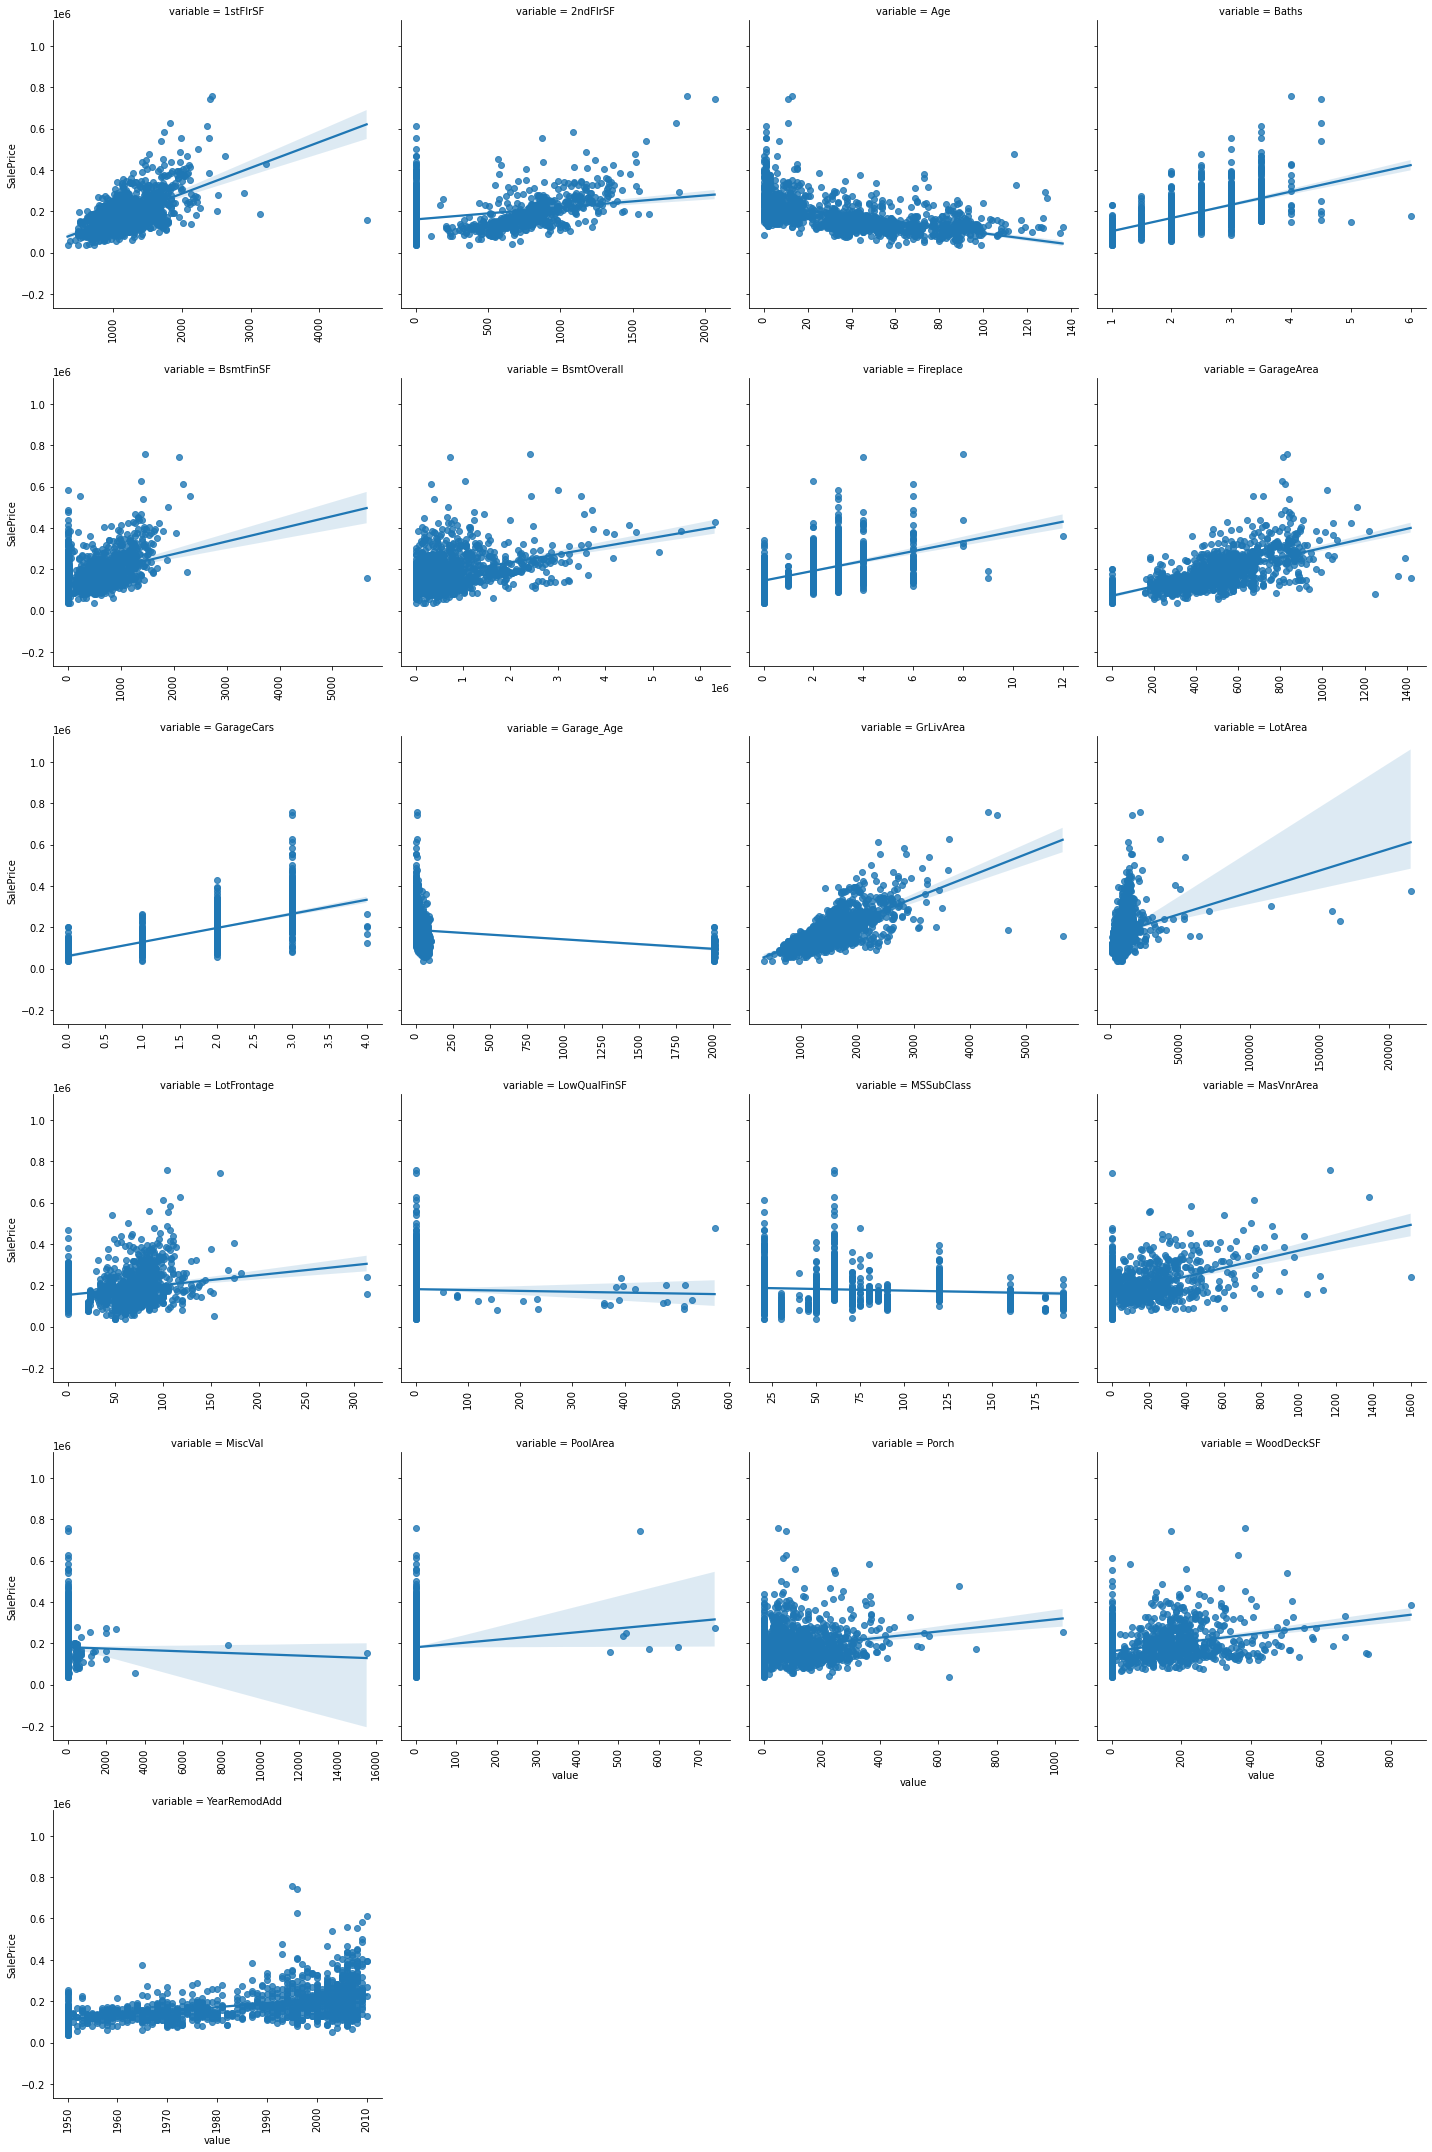

In [27]:
%%time
def scatterplot(x,y,**kwargs):
    sns.regplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df_combined[df_combined.source == "train"], id_vars=['SalePrice'], value_vars=sorted(num))
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=True, height=5)
g = g.map(scatterplot, "value", "SalePrice")

CPU times: user 3.13 s, sys: 36.5 ms, total: 3.17 s
Wall time: 3.18 s


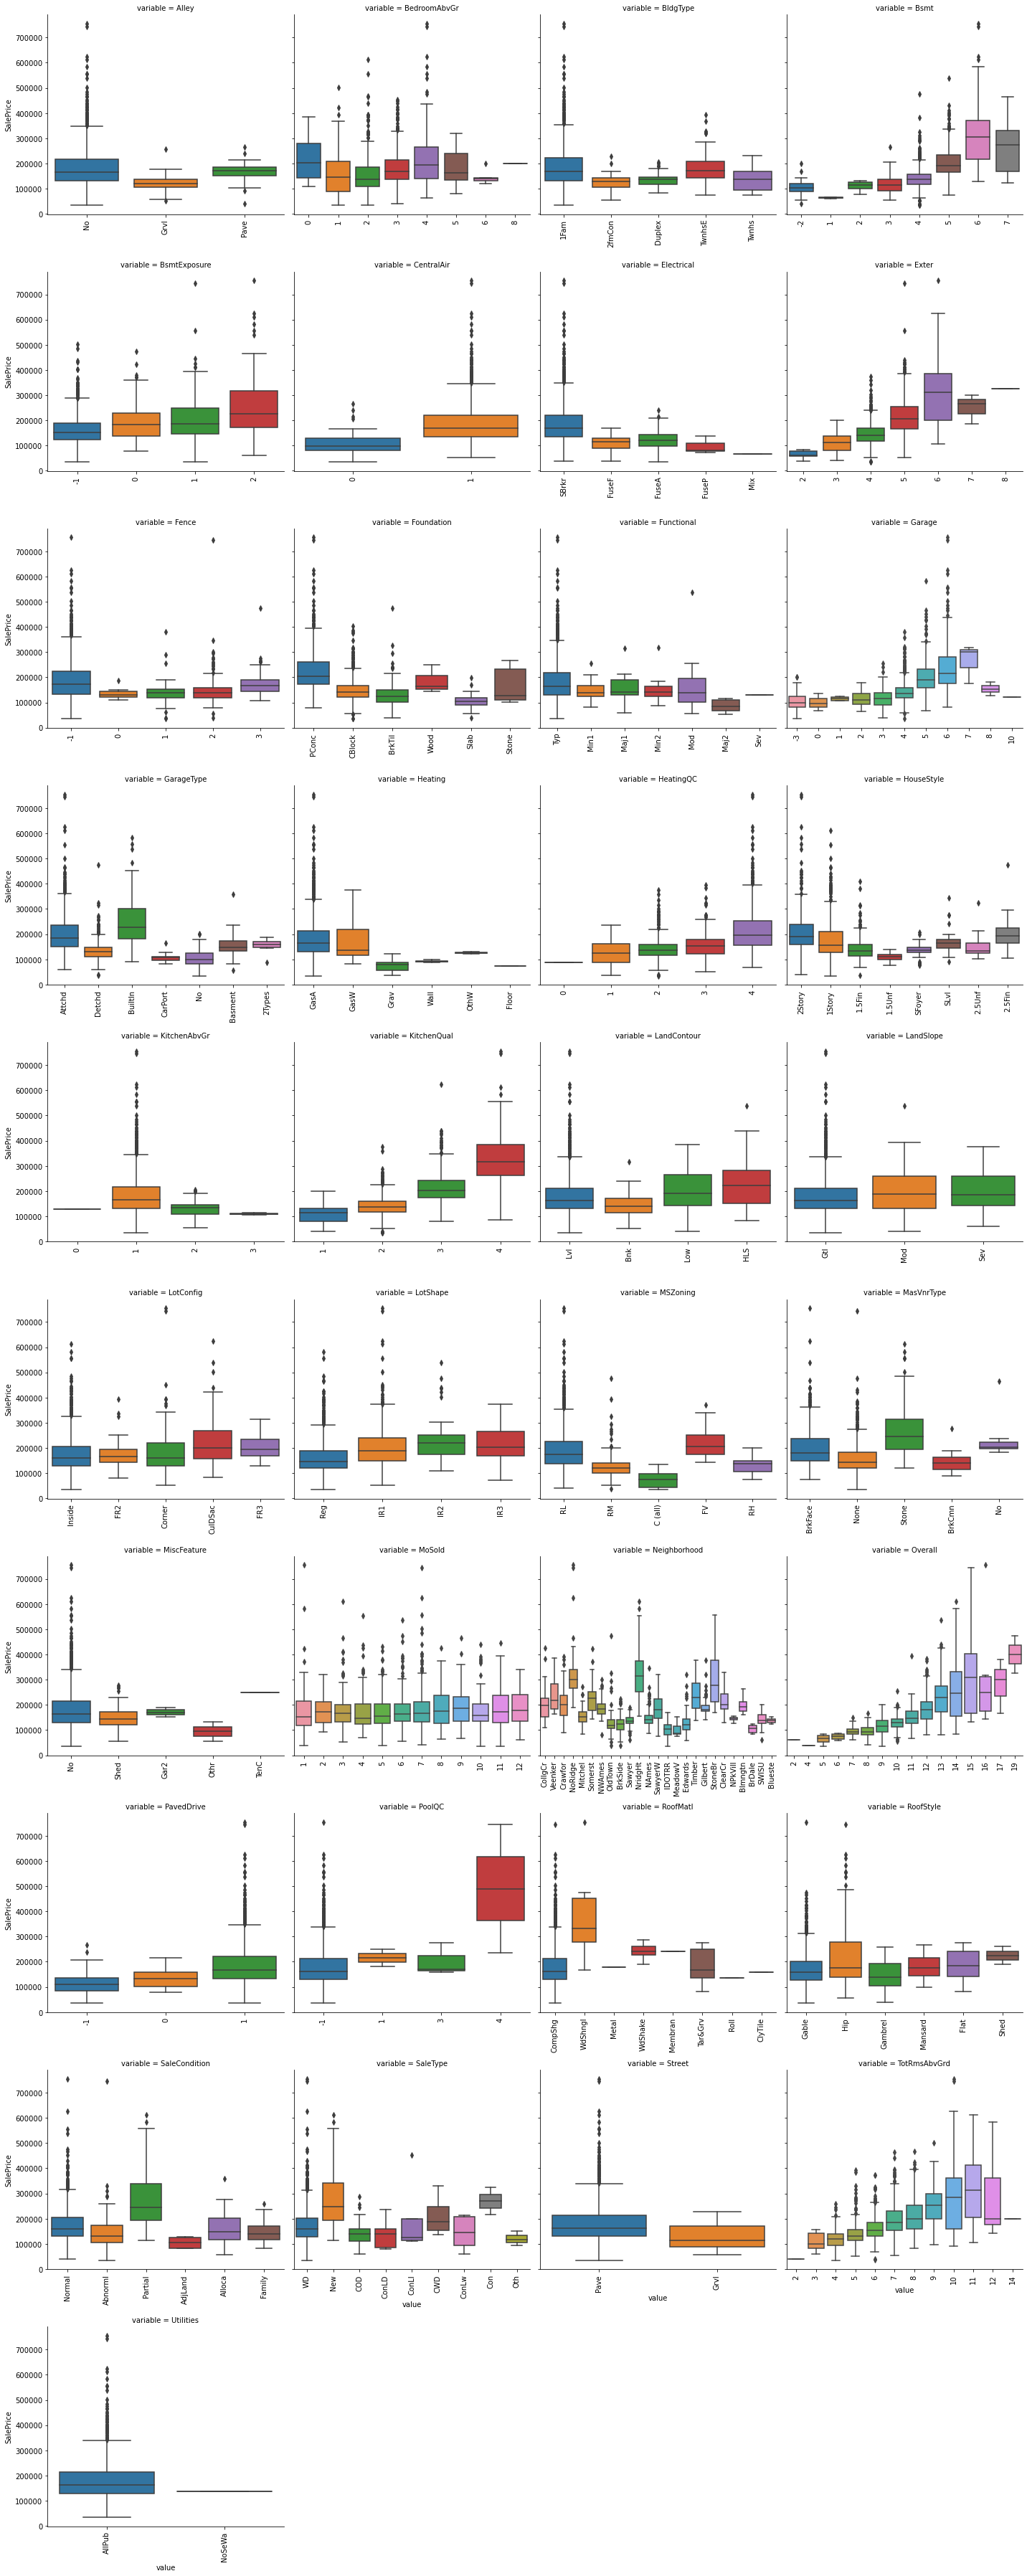

In [28]:
%%time
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df_combined[df_combined.source == "train"], id_vars=['SalePrice'], value_vars=cate)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=True, height=5)
g = g.map(boxplot, "value", "SalePrice")

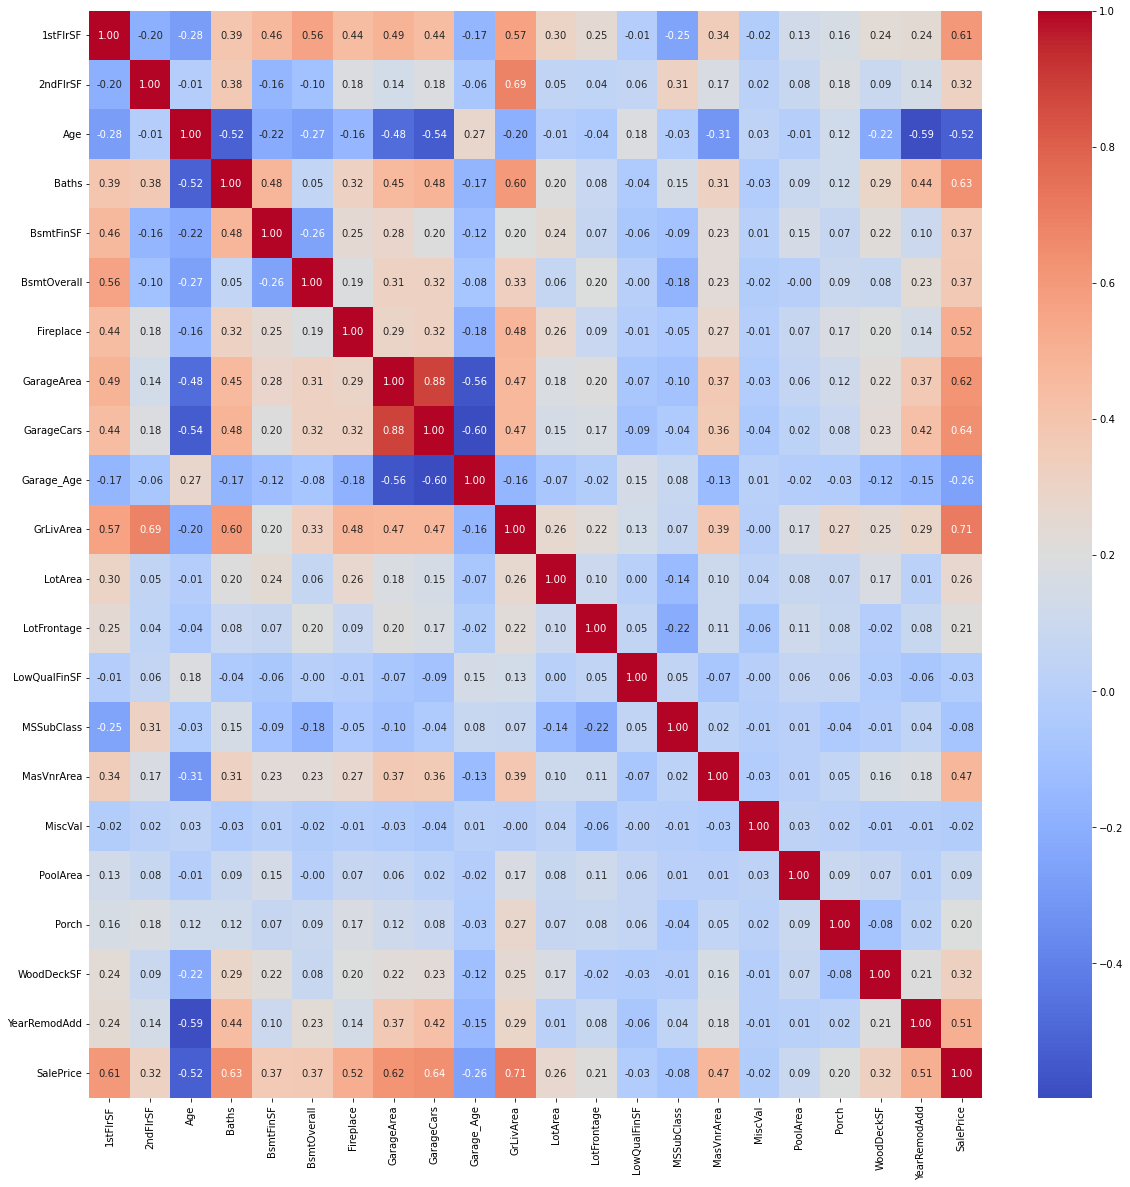

In [29]:
fig, ax = plt.subplots(figsize=(20,20))     
g = sns.heatmap(df_combined[df_combined.source == 'train'][[*num,'SalePrice']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

##### outlier for sale price

In [30]:
df_combined = df_combined.drop(df_combined[(df_combined['source']=='train') & (df_combined['1stFlrSF']> 4000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['source']=='train') & (df_combined['2ndFlrSF']> 2000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['source']=='train') & (df_combined['BsmtFinSF']> 5000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['source']=='train') & (df_combined['GarageArea']> 1300)].index)
df_combined = df_combined.drop(df_combined[(df_combined['source']=='train') & (df_combined['GrLivArea']> 5000)].index)


### nomalise numeric values

In [31]:
ss = StandardScaler()
df_combined[num] = ss.fit_transform(df_combined[num])

In [32]:
cond = df_combined[['Condition1','Condition2']]
condition_cats = ["Condition_"+s for s in set([*cond.Condition1.unique(), *cond.Condition2.unique()])]
COND_FRAME = pd.DataFrame(columns=condition_cats, index = df_combined.index).fillna(0)
for i in cond.index:
    cs = set(cond.loc[i, ['Condition1','Condition2']].values)
    for c in cs:
        COND_FRAME.loc[i]['Condition_'+c] = 1

df_combined = df_combined.join(COND_FRAME)
df_combined.drop(['Condition1','Condition2'], axis=1, inplace=True)

CPU times: user 425 ms, sys: 4.58 ms, total: 430 ms
Wall time: 429 ms


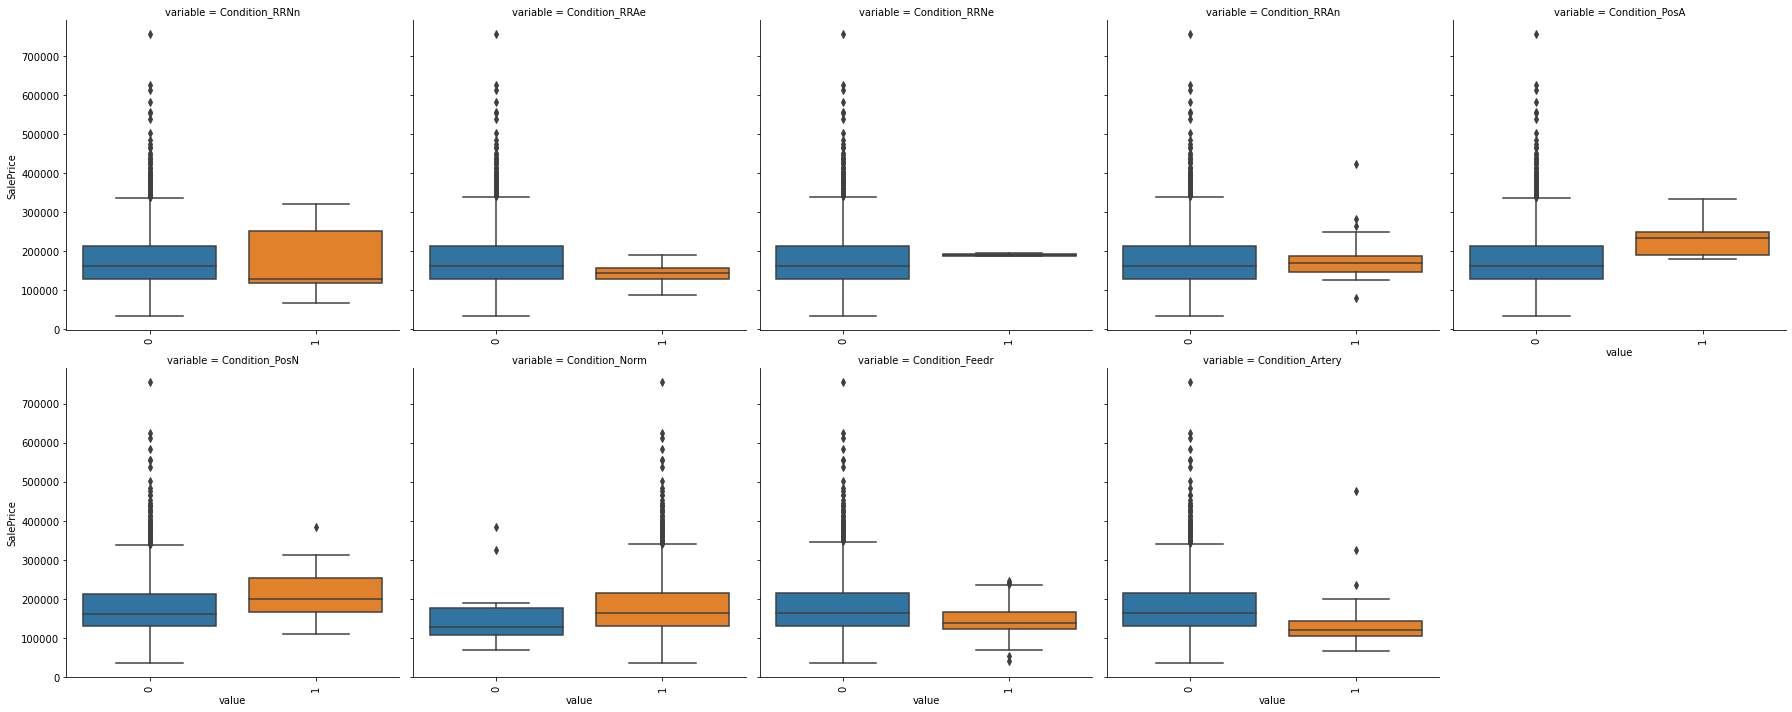

In [33]:
%%time
def scatterplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df_combined[df_combined.source == "train"], id_vars=['SalePrice'], value_vars=df_combined[df_combined.source == 'train'][df_combined.filter(like='Condition_').columns])
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=True, height=5)
g = g.map(scatterplot, "value", "SalePrice")

In [34]:
ext = df_combined[['Exterior1st','Exterior2nd']]
ext_cats = ["Ext_"+s for s in set([*ext.Exterior1st.unique(), *ext.Exterior2nd.unique()])]
EXT_FRAME = pd.DataFrame(columns=ext_cats, index = df_combined.index).fillna(0)
for i in ext.index:
    cs = set(ext.loc[i, ['Exterior1st','Exterior2nd']].values)
    for c in cs:
        EXT_FRAME.loc[i]['Ext_'+c] = 1

df_combined = df_combined.join(EXT_FRAME)
df_combined.drop(['Exterior1st','Exterior2nd'], axis=1, inplace=True)

CPU times: user 1.02 s, sys: 7.78 ms, total: 1.03 s
Wall time: 1.03 s


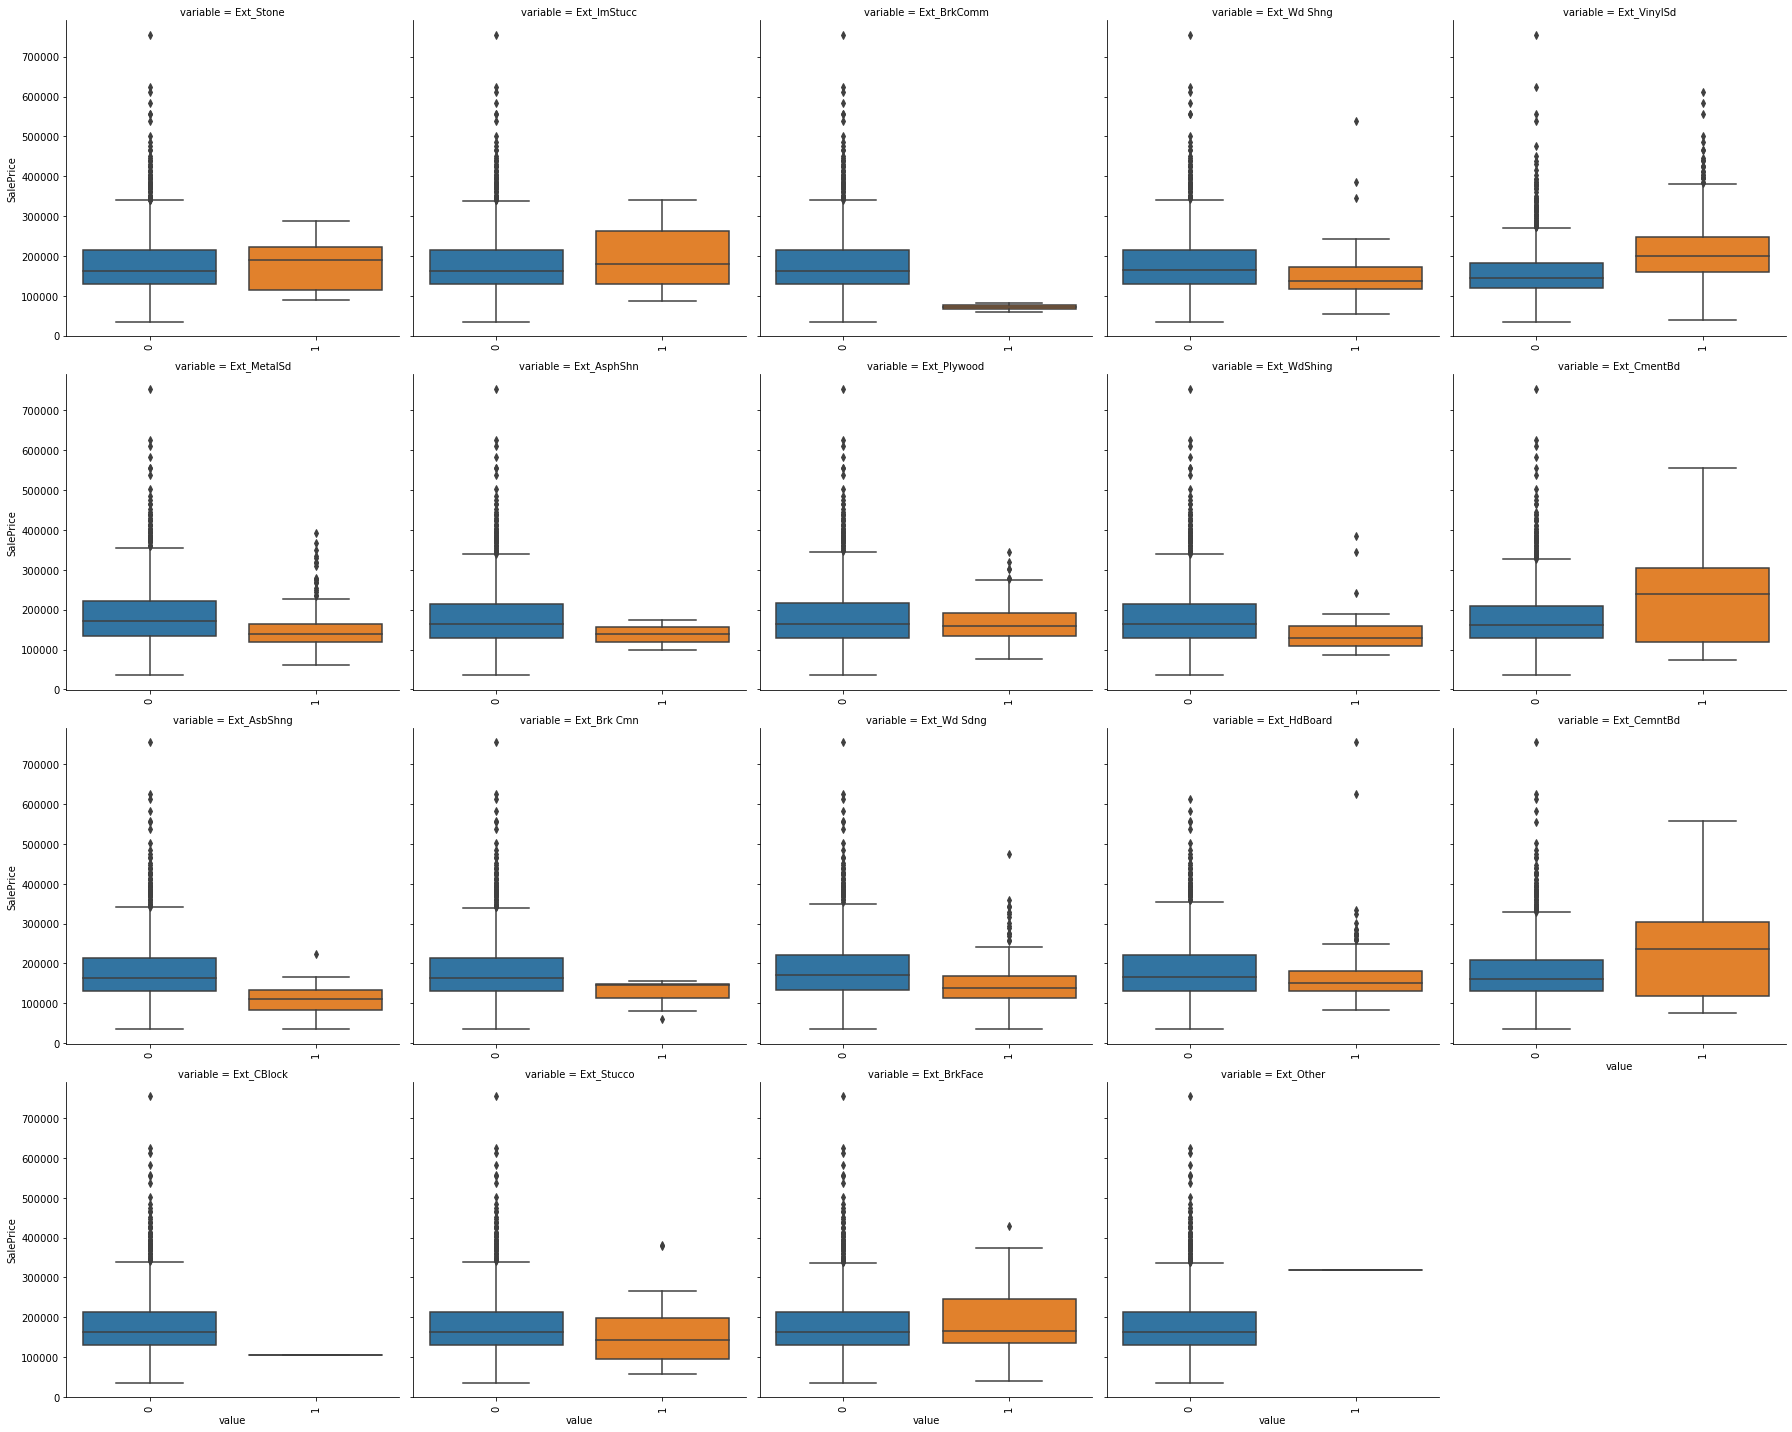

In [35]:
%%time
def scatterplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df_combined[df_combined.source == "train"], id_vars=['SalePrice'], value_vars=df_combined[df_combined.source == 'train'][df_combined.filter(like='Ext_').columns])
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=True, height=5)
g = g.map(scatterplot, "value", "SalePrice")

In [36]:
bf = df_combined[['BsmtFinType1','BsmtFinType2']]
bf_cats = ["BF_"+s for s in set([*bf.BsmtFinType1.unique(), *bf.BsmtFinType2.unique()])]
BF_FRAME = pd.DataFrame(columns=bf_cats, index = df_combined.index).fillna(0)
for i in bf.index:
    cs = set(bf.loc[i, ['BsmtFinType1','BsmtFinType2']].values)
    for c in cs:
        BF_FRAME.loc[i]['BF_'+c] = 1

df_combined = df_combined.join(BF_FRAME)
df_combined.drop(['BsmtFinType1','BsmtFinType2'], axis=1, inplace=True)

In [37]:
df_combined = pd.get_dummies(df_combined,columns=cate)

### Upload transformed data

In [38]:
df_combined.to_sql('transformed_combined', dbConnection, if_exists='replace', index=False)

In [ ]:
df_profile.to_sql('raw_data_profile', dbConnection, if_exists='replace', index=False, method='multi')